Created June 21, 2023

Updated Aug 7, 2023

### Created to plot the results of kmeans grouping the redpy clusters spatially and temporally

In [1]:
#imports
import numpy as np #for math and np.unique
import pandas as pd #for dataframes and reading/saving csvs
import matplotlib.pyplot as plt #for plotting
import rasterio as rio #for reading in DEM
from rasterio.plot import show #for plotting with rio
from matplotlib.gridspec import GridSpec #for organizing subplots
import math #for organizing subplots (math.ciel and math.floor)
import h5py #for reading in waveforms
import yaml #for reading in config
from glob import glob #for pulling in multiple event csvs

In [11]:
#config params
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

homedir = config['homedir']
readdir = config['readdir']

# vv = config['vv']
vv=3
volc_list_names = config['volc_list_names']
volc = volc_list_names[vv]
print(volc)

Rainier


In [6]:
#params to chose
#pull in cop-kmeans results (code currently on laptop which has the cop kmeans package installed)
k = 4
#set station to look at waveforms from
sta = 'hood' #must be lowercase, must be at the volcano you are looking at, see Volcano_Metadata.csv for options
#number of states for fingerprint
states = 30
#pca ('') or tsne ('tsne_')
ver = 'tsne_'
#'normalized_' or ''
norm = 'normalized_'
#kmeans file name, set manually or let k and sta pull it in
# kmeans_filename = 'Hood_HOOD_cop_kmeans.csv'
kmeans_filename = f'{norm}{ver}{volc}_k_{k}_cl_grps_{states}_states.csv'
print(kmeans_filename)

normalized_tsne_Hood_k_4_cl_grps_30_states.csv


In [47]:
#pull things in from params
cl_k_grp = pd.read_csv(f'{homedir}cop_kmeans/{kmeans_filename}')
if type(cl_k_grp['cluster_id'].values[0])==np.int64: #if cluster ids were saved as an int
    print('type int')
    cl_k_grp['cluster_id']=[f'b\'{str(i).zfill(3)}\'' for i in cl_k_grp['cluster_id']] #immitate byte for formatting consistency

#pull in cluster locations
locs = pd.read_csv(f'{homedir}locations/{volc}_Template_Locations.csv')
#pull volcano metadata for station location
volc_md = pd.read_csv(f'{readdir}Volcano_Metadata.csv')

#pull in event catalog
if volc == 'St_Helens': #for Helens, must concat catalogs, same code as in make_templates
    St_Helens = pd.read_csv(readdir+'MountStHelens_catalog.csv')
    # Combining borehole and local catalogs with St_Helens
    Helens_Borehole = pd.read_csv(readdir+'MSHborehole_catalog.csv')
    Helens_Borehole['Clustered'] += 2000 
    # Cluster 0 in Helens_Borehole is now Cluster 2000 in St_Helens
    Helens_Local = pd.read_csv(readdir+'MSHlocal_catalog.csv')
    Helens_Local['Clustered'] += 3000
    # Cluster 0 in Helens_Local is now Cluster 3000 in St_Helens
    # Use St_Helens to access all three St Helens catalogs
    volc_ctlg = pd.concat([St_Helens,Helens_Borehole,Helens_Local])
else:
    volc_ctlg = pd.read_csv(f'/home/smocz/expand_redpy/csv_catalogs/{volc}_catalog.csv')

if volc_md[volc_md["Station"]==sta.upper()]["Volcano_Name"].values.tolist()[0] != volc: print('STATION IS NOT AT THE PROPER VOLCANO')
sta_lat = volc_md[volc_md["Station"]==sta.upper()]["Latitude"].values.tolist()[0]
sta_lon = volc_md[volc_md["Station"]==sta.upper()]["Longitude"].values.tolist()[0]
print(sta,sta_lat,sta_lon)

type int
hood 45.322262 -121.650932


In [48]:
cl_k_grp.head()

,cluster_id,kmeans_grp
0,b'000',3
1,b'001',2
2,b'010',2
3,b'100',1
4,b'102',1


In [49]:
#pull in waveforms
with h5py.File(f"/home/smocz/expand_redpy_new_files/h5/new_normalized_{volc.lower()}_templates_{states}_states.h5", "r") as f: #pull in fingerprints
    fingerprints = f["fingerprints"][()]
    template_name = f["template_name"][()]
    waveforms = f["waveforms"][()]
    print(f.keys()) #print what data is in this file
    
print(template_name[0])

<KeysViewHDF5 ['fingerprints', 'template_name', 'waveforms']>
b'CC_BRSP_rpho_10'


### Location (DEM)

In [50]:
#get locations of clusters
cl_list = [] #will be a list of all clusters with locations
kmeans_grp = [] #will be a list of the kmeans group for each cluster saved
lats = [] #will be a list of all latitude points (indexes match with cl_list)
lons = [] #will be a list of all longitude points (indexes match with cl_list)
for cc,cl in enumerate(cl_k_grp['cluster_id'].values.tolist()):
#     print('---')
#     print('cl',int(cl[2:-1]))
    try:
        lat = locs[locs["Cluster_ID"]==int(cl[2:-1])]["Latitude"].item() #get the associated latitude
        lats.append(lat) #append
        lon = locs[locs["Cluster_ID"]==int(cl[2:-1])]["Longitude"].item() #get the associated longitude
        lons.append(lon) #append
        cl_list.append(cl[2:-1]) #append cl id
        kmeans_grp.append(cl_k_grp['kmeans_grp'].values.tolist()[cc]) #append kmeans id
#         print(lat,lon)
    except:
#         print('no location')
        continue

locdf = pd.DataFrame({"cluster_id":cl_list,"kmeans_grp":kmeans_grp,"latitude":lats,"longitude":lons}) #create df
locdf.head()

,cluster_id,kmeans_grp,latitude,longitude
0,001,2,45.354359,-121.680020
1,010,2,45.376863,-121.683080
2,100,1,45.374434,-121.625646
3,102,1,45.354252,-121.644926
4,103,3,45.354168,-121.619403


Plot locations on DEM

In [51]:
#set up info for DEM plot
dem = rio.open("/home/smocz/expand_redpy_new_files/DEM_data/Hood.tif") #open tif file with rio
dem_array = dem.read(1).astype('float64') #set array for DEM
crs = dem.crs #get crs (coordinate reference systems)
dem_data_dict={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1],
               'top':dem.bounds[3]} #extract boundaries
#set volcano center
center_lat = 46.8528857
center_lon = -121.7603744

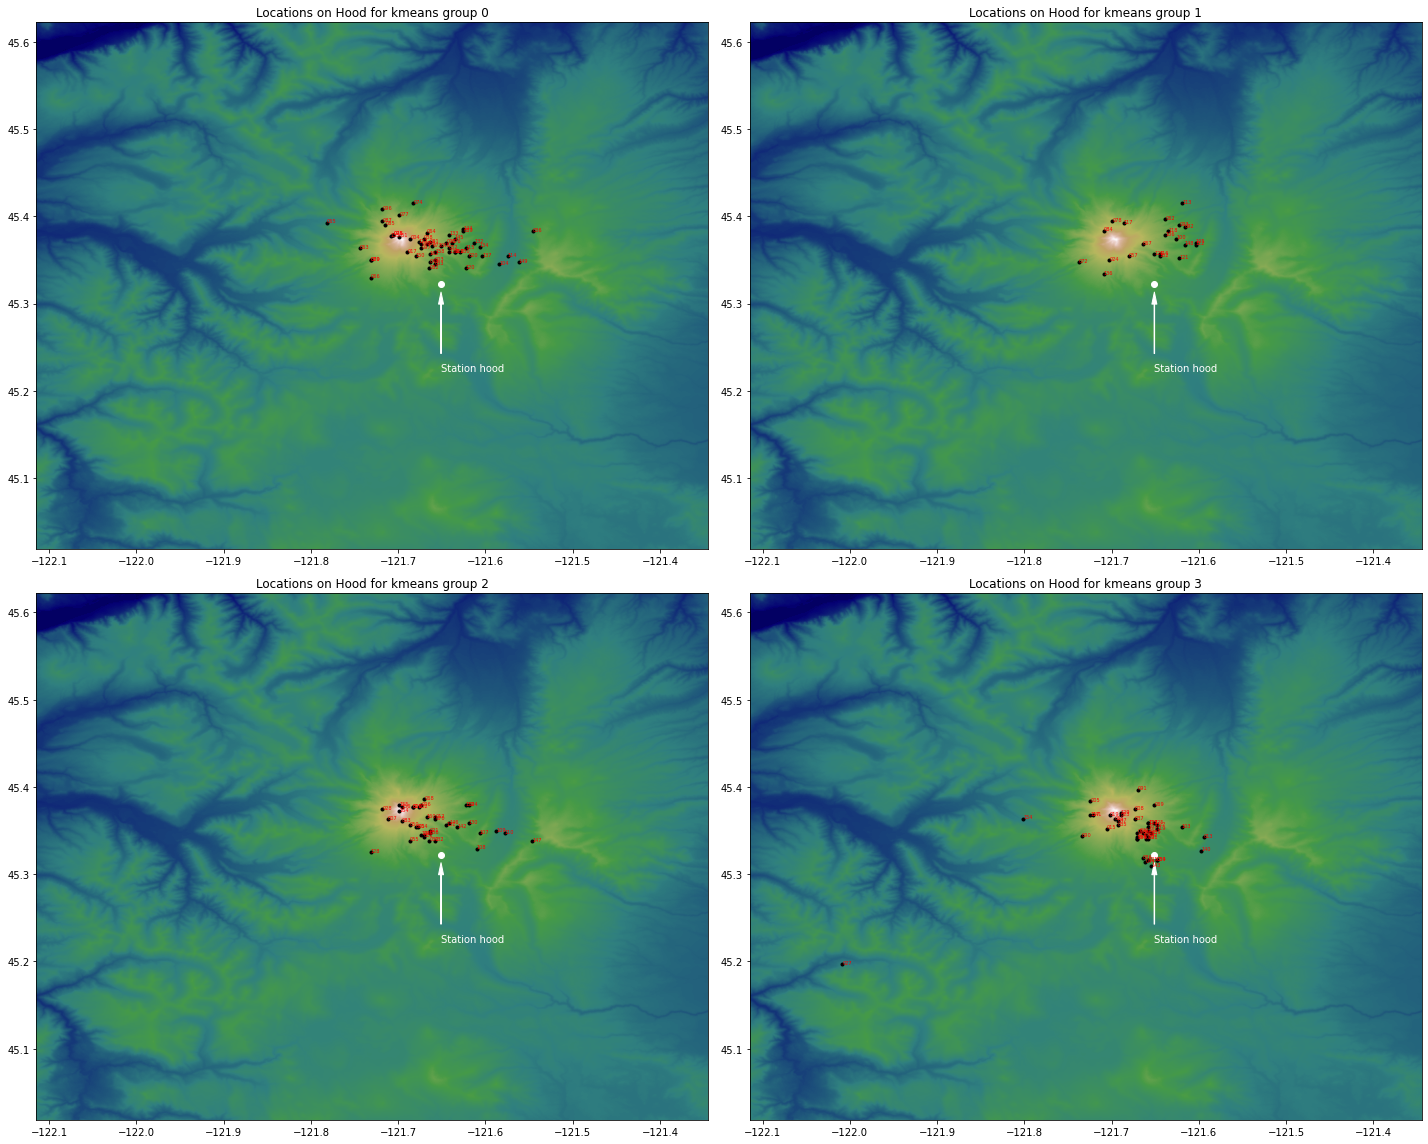

In [52]:
data = dem_data_dict['data']
left,right,bottom,top = dem_data_dict['left'],dem_data_dict['right'],\
                        dem_data_dict['bottom'],dem_data_dict['top']

ncols = math.ceil(k/2) #number of columns for the map plot, based on k or can be entered manually
nrows = math.ceil(k/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*10,nrows*8))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.set_tight_layout(True)

for aa in range(0,k):#for each subplot
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1, \
            aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    
    ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth') #plot DEM
    ax.set_title(f'Locations on {volc} for kmeans group {aa}') #title
    lons = locdf[locdf['kmeans_grp']==aa]['longitude'].values.tolist()
    lats = locdf[locdf['kmeans_grp']==aa]['latitude'].values.tolist()
    ax.scatter(lons,lats,marker='.',color='k',label='Cluster Locations') #plotting some points

    ax.scatter(sta_lon,sta_lat,marker='o',color="white",label=f"station {sta.upper()}")
    ax.annotate(f'Station {sta}',xy=(sta_lon,sta_lat),xytext=(sta_lon,sta_lat-0.1),arrowprops=dict(color='white', headwidth=5, shrink=0.1, width=0.5), color='white',size=10)
    
    for point,name in zip([(i,ii) for i,ii in zip(lons,lats)], \
                          locdf[locdf['kmeans_grp']==aa]['cluster_id'].values.tolist()):
        ax.annotate(name,xy=point,color='red',size=5)
    
    #crop/zoom-in on map
    ax.set_xlim(left+0.3,right-0.4) #set manually to what looks best
    ax.set_ylim(bottom+0.1,top-0.2) #set manually to what looks best
fig.delaxes(ax0) #remove unused ax

# fig.savefig(f'/home/smocz/expand_redpy_new_files/cop_kmeans/{ver}normalized_{volc}_DEM_loc_{k}_{states}_states_labeled.svg')

### Time (Bar)

In [53]:
#pull in new events (from eqcorrscan backfilling)

#glob the event csvs (loop)
pd_list = []
for x in glob(f'{homedir}events/{volc}_*_events.csv'):
    pd_list.append(pd.read_csv(x))
#concat them into one csv
nd_df = pd.concat(pd_list)
#only have datetime and cluster id column
nd_df = nd_df.drop('Stations_Found',axis='columns')
nd_df = nd_df.drop('Stations',axis='columns')

nd_df.head()

,Earliest_Detection_Time,Cluster_ID
0,2020-03-21T07:28:00.601423Z,2
1,2020-08-31T16:48:35.325747Z,2
2,2020-12-13T13:30:01.450845Z,2
3,2020-11-17T14:20:07.159998Z,6
4,2020-11-05T11:28:04.975000Z,8


In [54]:
#list of summer months for colors (winter months are just months NOT in this list)
summer_months = list(np.arange(4,10,1)) #apr-sep (winter is then oct-mar)
print(summer_months)

[4, 5, 6, 7, 8, 9]


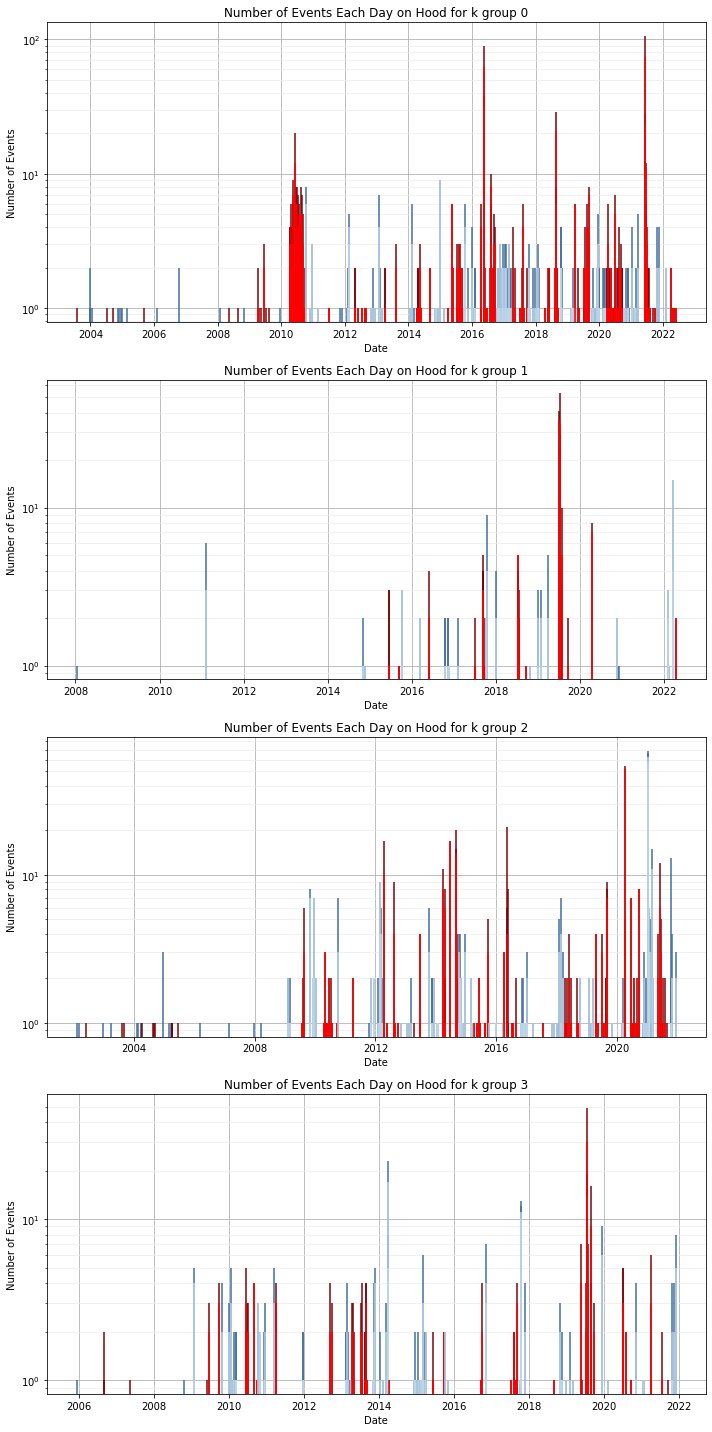

In [55]:
ncols = 1 #number of columns, stays consistent
nrows = math.ceil(k/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*10,nrows*5))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.set_tight_layout(True)

for aa in range(0,k): #for each kmeans group
    
    ### find data for plotting ###
    dt_list = [] #will be a list of all the dates (redpy and eqcorrscan)
    r_dt_list = [] #list of just redpy dates
    
    cl_list = [cl[2:-1] for cl in cl_k_grp[cl_k_grp['kmeans_grp']==aa]['cluster_id'].values.tolist()] #list of cl in kmeans group
    for cl in cl_list: #for each cluster in that group
        d_list = [d[:10] for d in volc_ctlg[volc_ctlg['Clustered']==int(cl)]['datetime'].values.tolist()] #list of dates
        nd_list = [d[:10] for d in nd_df[nd_df['Cluster_ID']==int(cl)]['Earliest_Detection_Time'].values.tolist()] #list of new dates
        [dt_list.append(d) for d in d_list] #append to overall list
        [r_dt_list.append(d) for d in d_list] #append to only redpy list
        [dt_list.append(d) for d in nd_list] #append new dates (from eqcorrscan) to overall list
    num_list = [dt_list.count(i) for i in np.unique(dt_list)] #count how many instances of a date appear in dt_list
    r_num_list = [r_dt_list.count(i) for i in np.unique(r_dt_list)] #count instances of redpy detections
    
    df = pd.DataFrame({"date":np.unique(dt_list),"number_events":num_list})
    r_df = pd.DataFrame({"date":np.unique(r_dt_list),"number_events":r_num_list})
    
    ### plot ###
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1, \
            aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    x = pd.to_datetime([str(i) for i in df['date'].values.tolist()]) #read dates as string to pd datetime
    y = df['number_events'].values.tolist() #number of events per day, same index as date list(x)
    
    ax.grid(which='major')
    ax.grid(which='minor',color='#EEEEEE')

#     ax.scatter(x,y,label='REDPy Events', color='red') #s=40,alpha=0.75,marker='.',
    for xx,yy in zip(x,y): #plot eqcorrscan detections (taller lines)
        if xx.month in summer_months: #if its in summer
            plt.vlines(xx,ymin=0,ymax=yy, color='#7B0004')
        else: #if its in winter
            plt.vlines(xx,ymin=0,ymax=yy, color='#416D9F')
            
    #plotting redpy values (no eqcorrscan detections)
    x = pd.to_datetime([str(i) for i in r_df['date'].values.tolist()]) #read dates as string to pd datetime
    y = r_df['number_events'].values.tolist() #number of events per day, same index as date list(x)
    for xx,yy in zip(x,y):
        if xx.month in summer_months: #if its in summer
            plt.vlines(xx,ymin=0,ymax=yy, color='red')
        else: #if its in winter
            plt.vlines(xx,ymin=0,ymax=yy, color='#BFD7EA')

    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Events')
    ax.set_yscale('log') #or 'linear'
    ax.set_title(f'Number of Events Each Day on {volc} for k group {aa}')
#     print(aa,len(dt_list))

    
fig.delaxes(ax0) #remove unused ax

# fig.savefig(f'/home/smocz/expand_redpy_new_files/cop_kmeans/{ver}normalized_{volc}_time_{k}_{states}_states.svg')

### Waveforms

In [3]:
def getsta(t_name_str): #get station from normalized template name
    t_sta = str(t_name_str).split('_')[1]
#     t_sta = str(t_name_byt)[2:-1].split('_')[1]
    
    #t_net = str(t_name)[2:-1].split('_')[0] # can get net also
    return t_sta #, t_net

def getcl_id(t_name_str): #for normalized
    t_cl = t_name_str.split('_')[-1]
    return t_cl

#for non-normalized
# def getcl_id(t_name_str):
#     t_cl = str(t_name_str)[-3:] #for zfill of 3
#     return t_cl

In [26]:
plot_station = 'PARA'

In [27]:
all_temps = []
all_waves = []

for filepath in glob(f'/home/smocz/expand_redpy_new_files/h5/normalized_{volc_list_names[vv].lower()}_templates_*.h5'):
    net = filepath.split('_')[-2]
    with h5py.File(filepath, "r") as f: #pull in fingerprints
        template_name = f["template_name"][()]
        waveforms = f["waveforms"][()]
#         print(f.keys()) #print what data is in this file
    [all_temps.append(i) for i in template_name]
    [all_waves.append(i) for i in waveforms]
    
all_waves = np.array(all_waves)
all_temps = [str(i)[2:-1] for i in all_temps]


#get on station
n_waves = []
n_temps = []
for w,t in zip(list(all_waves),all_temps):
    if getsta(t)==plot_station:
        n_waves.append(w)
        n_temps.append(t)

wdf = pd.DataFrame({"template_name":list(n_temps),"wave":list(n_waves)})
wdf.head()

,template_name,wave
0,CC_PARA_rpra_0,"[0.08064187824527644, 0.07234416140302685, 0.0..."
1,CC_PARA_rpra_2,"[-0.006861644811591703, 0.018009974580277564, ..."
2,CC_PARA_rpra_13,"[0.005115749183094116, 0.003587049403975045, 0..."
3,CC_PARA_rpra_16,"[-0.02896314160448799, -0.014613123641653444, ..."
4,CC_PARA_rpra_18,"[0.011226829809069708, 0.0027865352507431586, ..."


In [28]:
feat_df = pd.read_csv('../Rainier_tsfel_features_clustered_kmeans.csv')

k_grps = []
for t in wdf['template_name']:
    k_grps.append(feat_df[feat_df['template']==t]['clusterID'].values.tolist()[0])

# print(k_grps)
    
wdf['kmeans']=k_grps

In [29]:
wdf.head()

,template_name,wave,kmeans
0,CC_PARA_rpra_0,"[0.08064187824527644, 0.07234416140302685, 0.0...",3
1,CC_PARA_rpra_2,"[-0.006861644811591703, 0.018009974580277564, ...",0
2,CC_PARA_rpra_13,"[0.005115749183094116, 0.003587049403975045, 0...",0
3,CC_PARA_rpra_16,"[-0.02896314160448799, -0.014613123641653444, ...",2
4,CC_PARA_rpra_18,"[0.011226829809069708, 0.0027865352507431586, ...",2


In [30]:
k=4

In [31]:
# #get dataframe with template names (cluster) and waveform and kmeans group at one station
# templates = []
# waves = []
# for tname in template_name: #for each template name
#     t_sta = getsta(tname)
#     if t_sta.lower() == sta: 
# #     if str(tname)[2:-1].startswith(sta): #use this for non-normalized template names
#         idx = list(template_name).index(tname)
#         t_wave = waveforms[idx]
#         templates.append(str(tname)[2:-1])
#         waves.append(t_wave)
# k_grps = []
# for t in templates:
#     #find which cluster it belongs to, and which kmeans group that belongs to
#     kn = cl_k_grp[cl_k_grp["cluster_id"]==(f'b\'{getcl_id(t).zfill(3)}\'')]["kmeans_grp"].values.tolist()
#     k_grps.append(kn[0])
# wdf = pd.DataFrame({"template_name":list(templates),"wave":list(waves),"kmeans":k_grps})
# wdf.head()

number of clusters = 4
39 waveforms, 42 waveforms, 21 waveforms, 104 waveforms, showing plot...


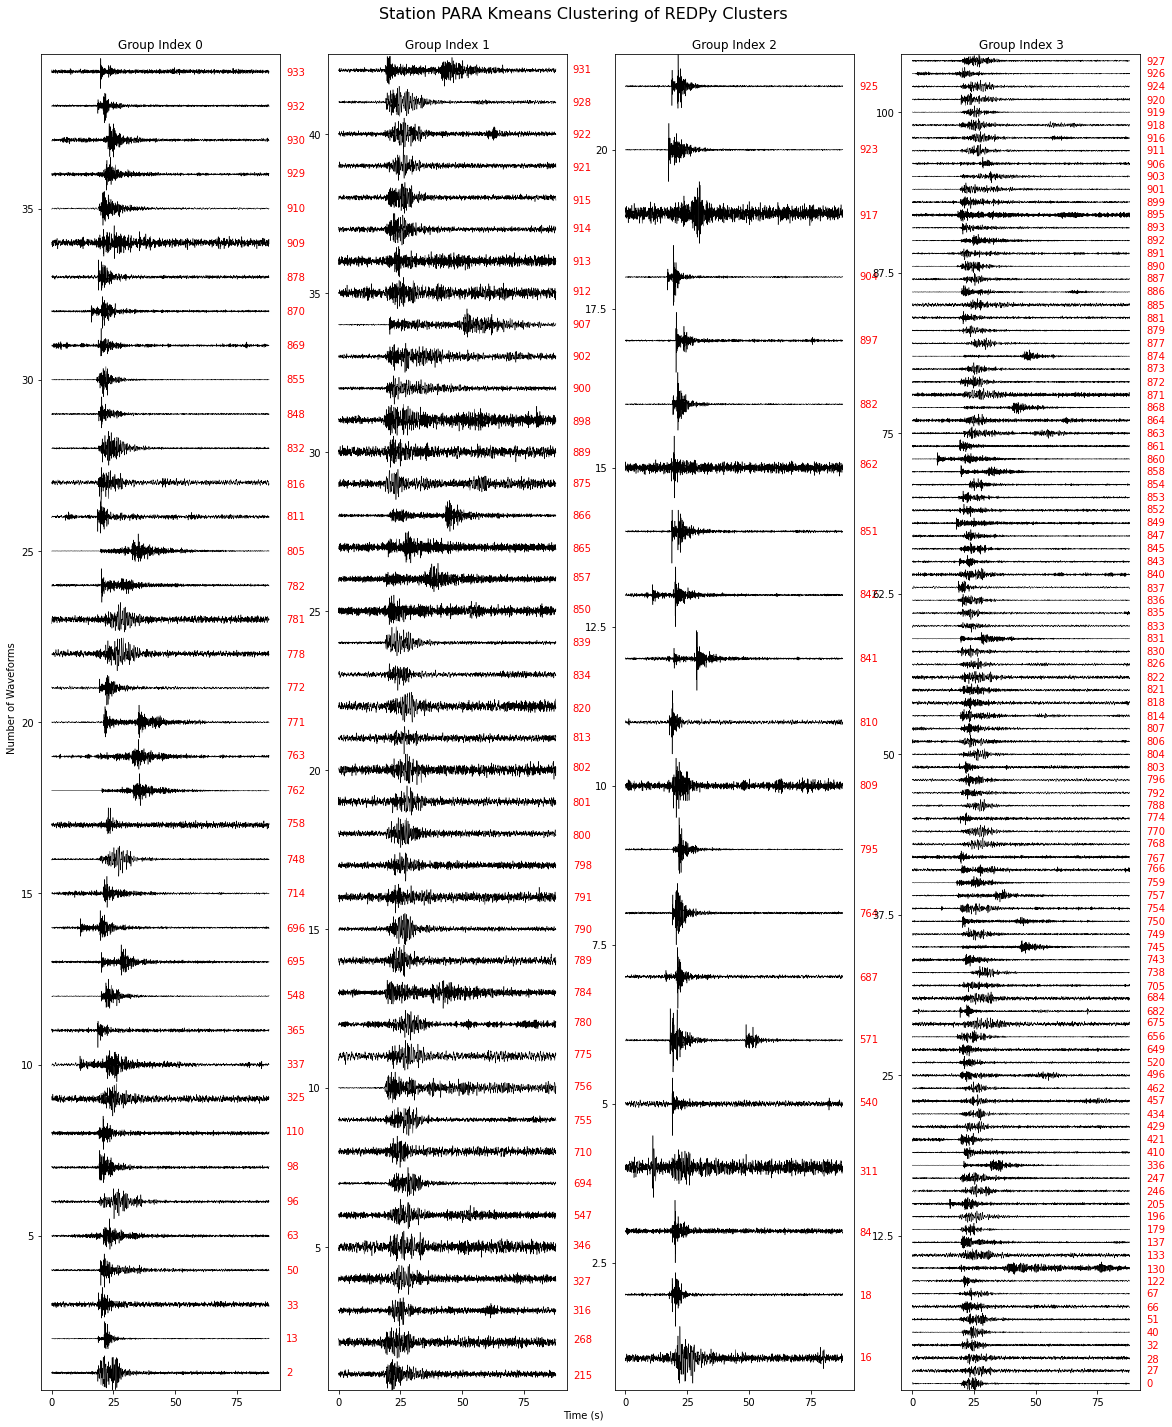

In [33]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import math
from obspy import Trace

print('number of clusters =',k)

ax_list = np.arange(0,k,1) #list of groups, can do np.arange(0,n_clusters,1)

ncols = k #number of columns, can be set manually
nrows = math.ceil(k/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*4,nrows*20))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.suptitle(f'Station {plot_station} Kmeans Clustering of REDPy Clusters',fontsize=16)
# fig.set_tight_layout(True)
fig.tight_layout(rect=[0, 0, 1, 0.975])


for aa,ax_n in enumerate(ax_list):#for each subplot
#     print(f'----{ax_n}----')
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1,aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    ax.set_title(f'Group Index {ax_n}') #label
    
    
    wave_list = [Trace(i) for i in wdf[wdf['kmeans']==aa]['wave'].values.tolist()] #list of waveforms for a Kmeans group
    name_list = [getcl_id(i) for i in wdf[wdf['kmeans']==aa]['template_name'].values.tolist()] #list of names for a Kmeans group

    print(len(wave_list),'waveforms', end=', ')
    
    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(wave_list):
        ax.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        
    for line, name in zip(ax.lines, name_list): #label each waveform with the cluster id
        y = line.get_ydata()[-1] #find the y value where the line ends
        ax.annotate(name, xy=(1,y), xytext=(6,0), color='red', 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=10, va="center")
    
    x = np.arange(0,len(wave.data),1) #get np array of x points
    xscale = 40 #samling rate in hz
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/xscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.xaxis.set_major_formatter(ticks) #set ticks
#     ax.set_xlabel('Time (s)')
    
    y = np.arange(1,len(wave_list),1) #get np array of y points
    #yscale defined above
    ticks = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/yscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.yaxis.set_major_formatter(ticks) #set ticks
    ax.set_ylim(1,(len(wave_list)*yscale)+(.5*yscale))
#     ax.set_ylabel('Number of Waveforms')
    
fig.delaxes(ax0) #remove unused ax
fig.text(0.5, 0.0, 'Time (s)', ha='center')
fig.text(0.0, 0.5, 'Number of Waveforms', va='center', rotation='vertical')

print('showing plot...')

# fig.savefig(f'/home/smocz/expand_redpy_new_files/cop_kmeans/{ver}normalized_{volc}_waveforms_{k}_{states}_states.svg')

### Fingerprints

In [59]:
#get dataframe with template names (cluster) and fingerprint and kmeans group at one station
templates = []
prints = []
for tname in template_name: #for each template name
    t_sta = getsta(tname)
    if t_sta.lower() == sta: 
#     if str(tname)[2:-1].startswith(sta): #use this for non-normalized template names
        idx = list(template_name).index(tname)
        t_print = fingerprints[idx]
        templates.append(str(tname)[2:-1])
        prints.append(t_print)
k_grps = []
for t in templates:
    #find which cluster it belongs to, and which kmeans group that belongs to
    kn = cl_k_grp[cl_k_grp["cluster_id"]==(f'b\'{getcl_id(t).zfill(3)}\'')]["kmeans_grp"].values.tolist()
    k_grps.append(kn[0])
fdf = pd.DataFrame({"template_name":list(templates),"fingerprints":list(prints),"kmeans":k_grps})
fdf.head()

,template_name,fingerprints,kmeans
0,UW_HOOD_rpho_0,"[[0.04370593398976047, 1.1867247457316956e-10,...",3
1,UW_HOOD_rpho_1,"[[0.14173963705847845, 0.05011252926348508, 0....",2
2,UW_HOOD_rpho_10,"[[0.13822399446274675, 0.04886956190365001, 0....",2
3,UW_HOOD_rpho_103,"[[0.3361462029418535, 0.05677434213714806, 0.0...",3
4,UW_HOOD_rpho_104,"[[1.642341298847829e-18, 1.642341298847829e-18...",0


40 fingerprints in 7 columns by 6 rows
17 fingerprints in 5 columns by 4 rows
35 fingerprints in 6 columns by 6 rows
39 fingerprints in 7 columns by 6 rows


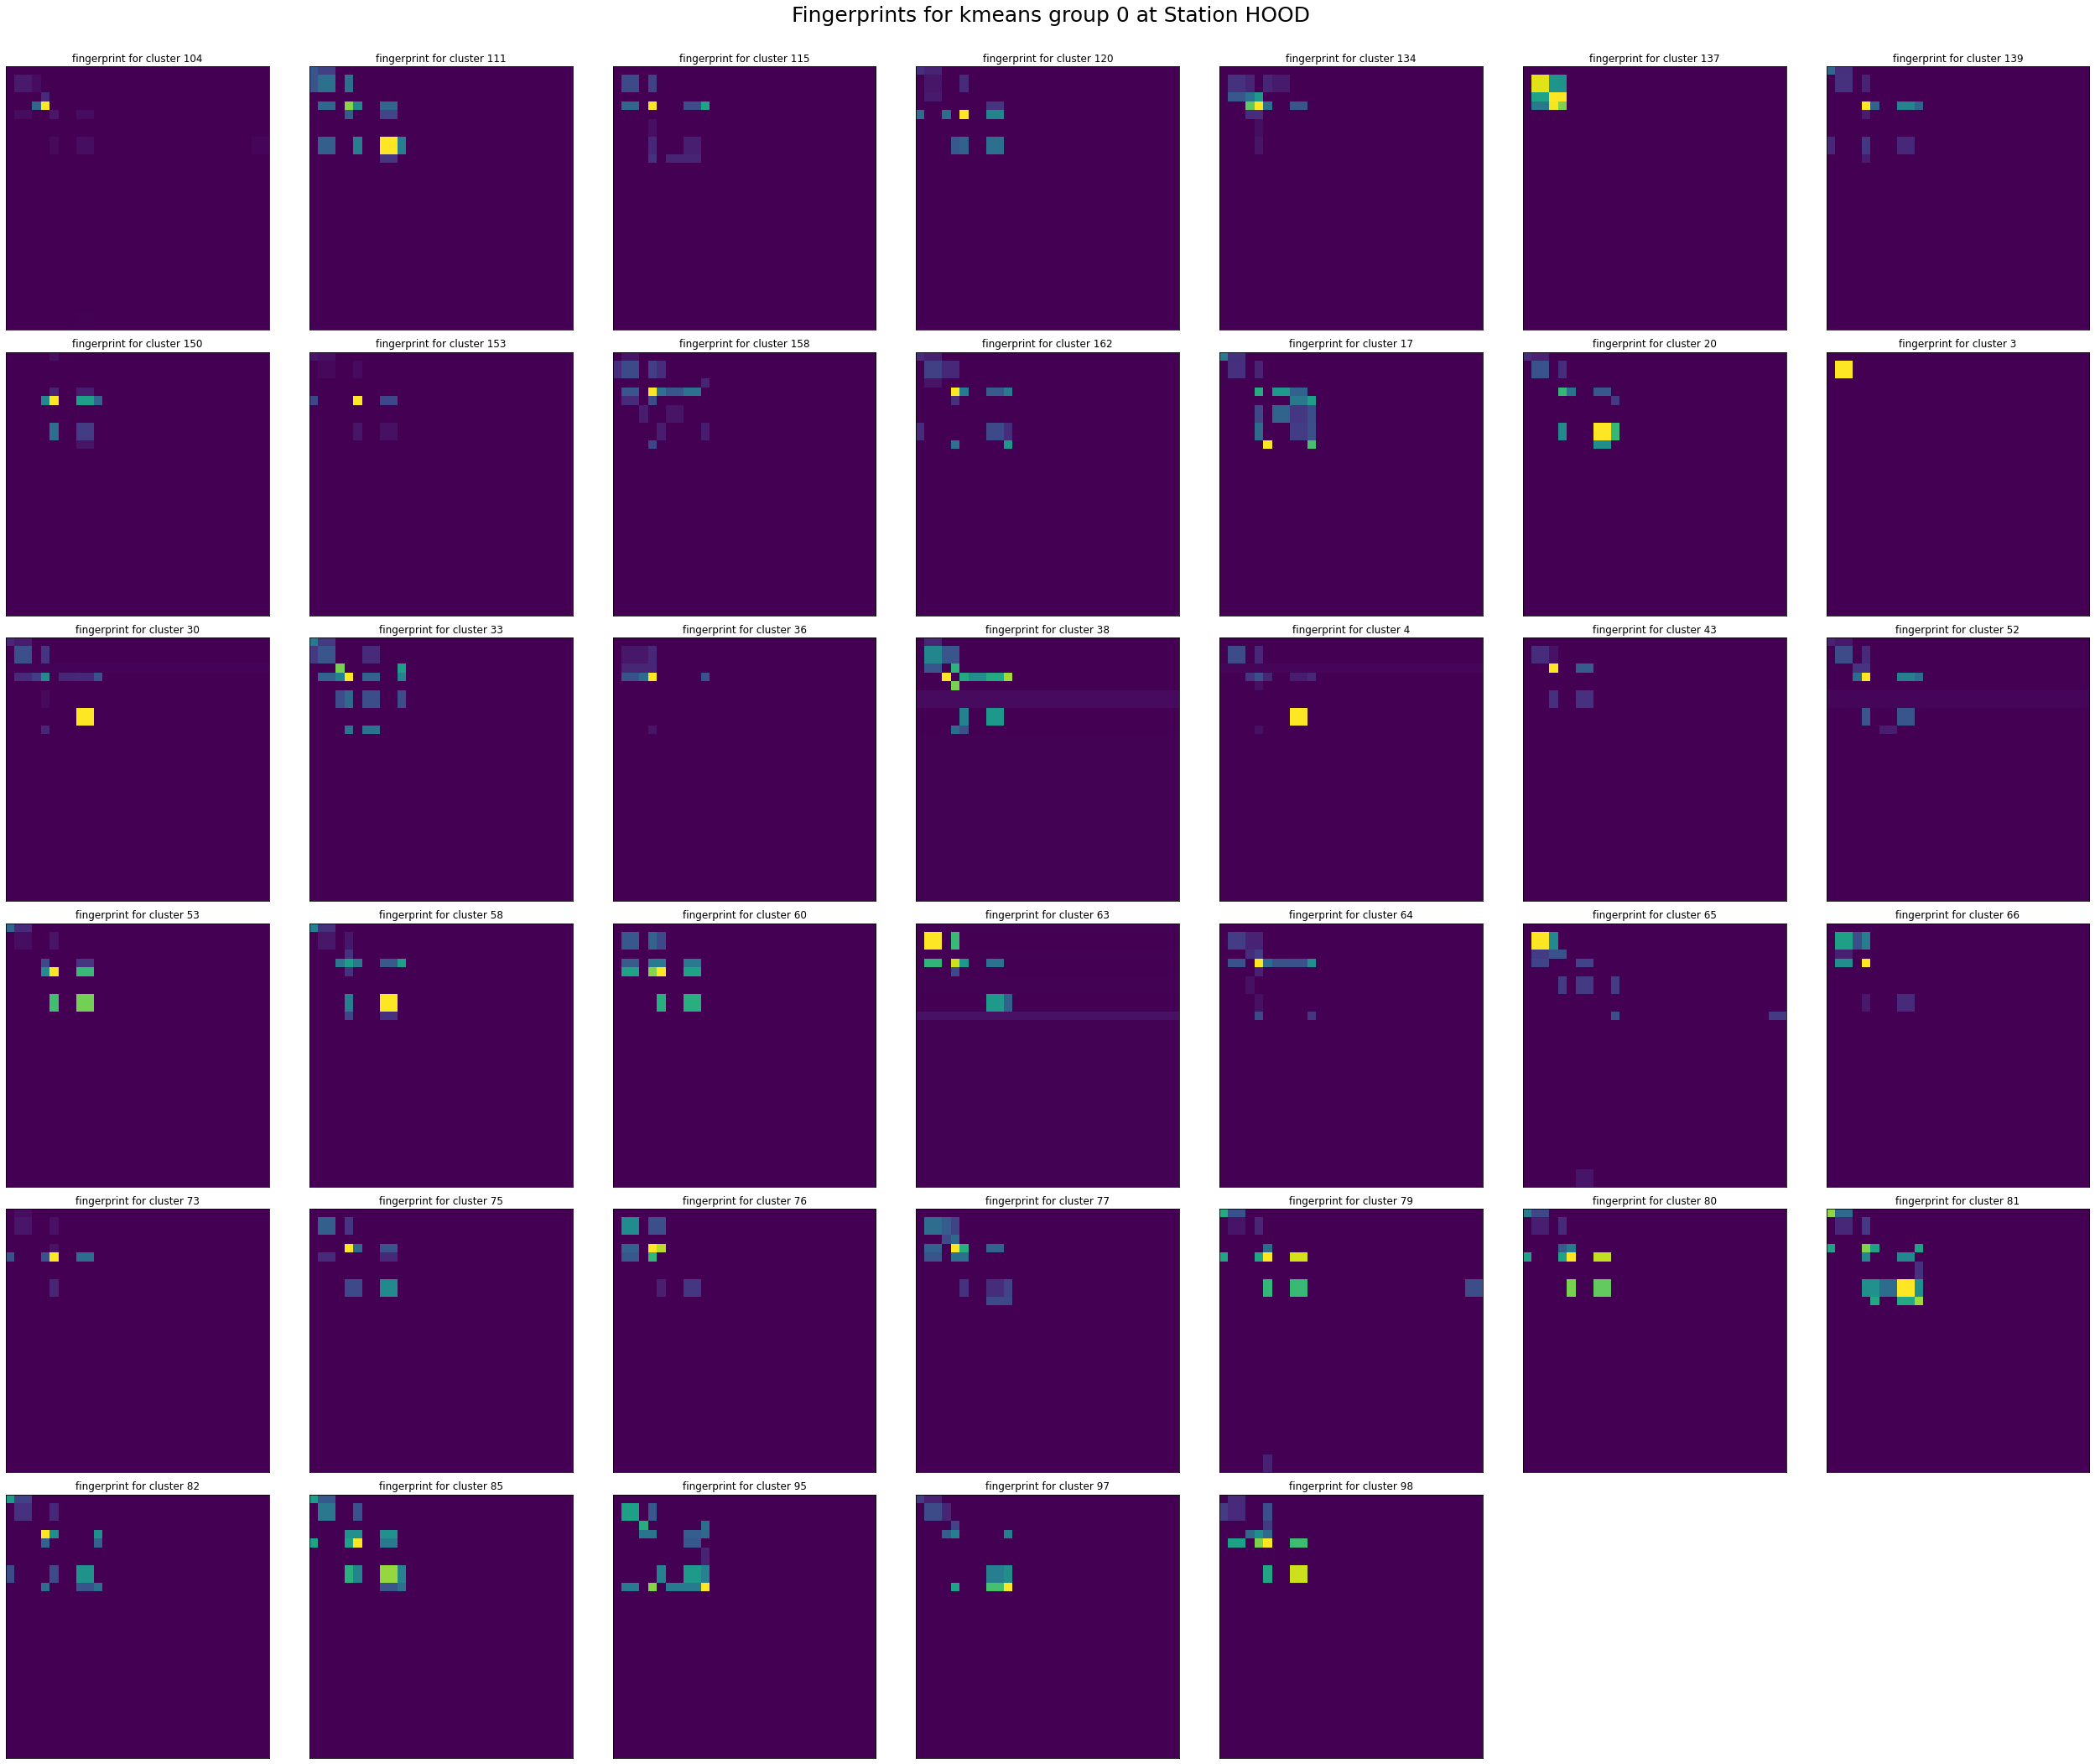

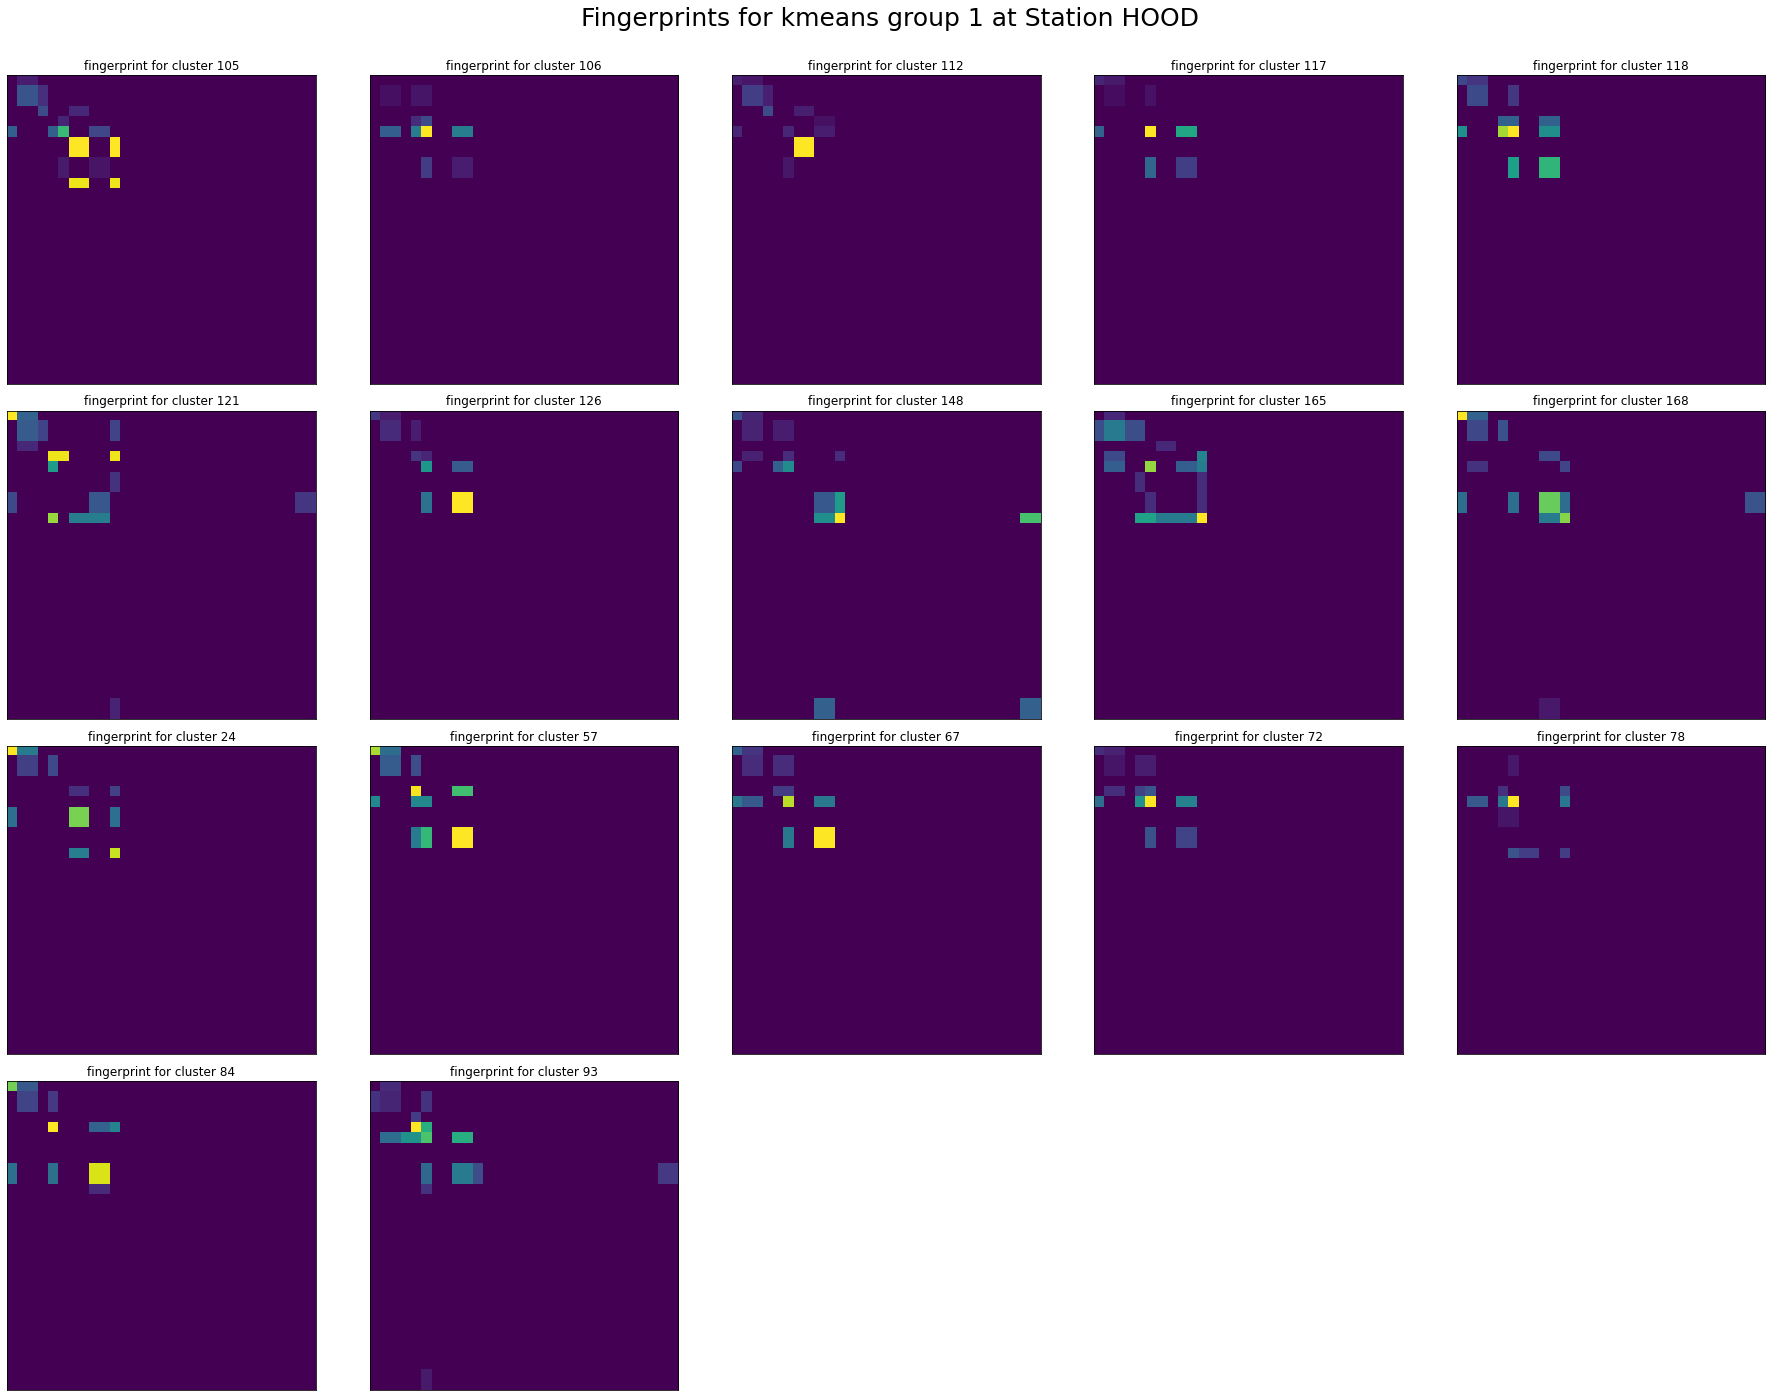

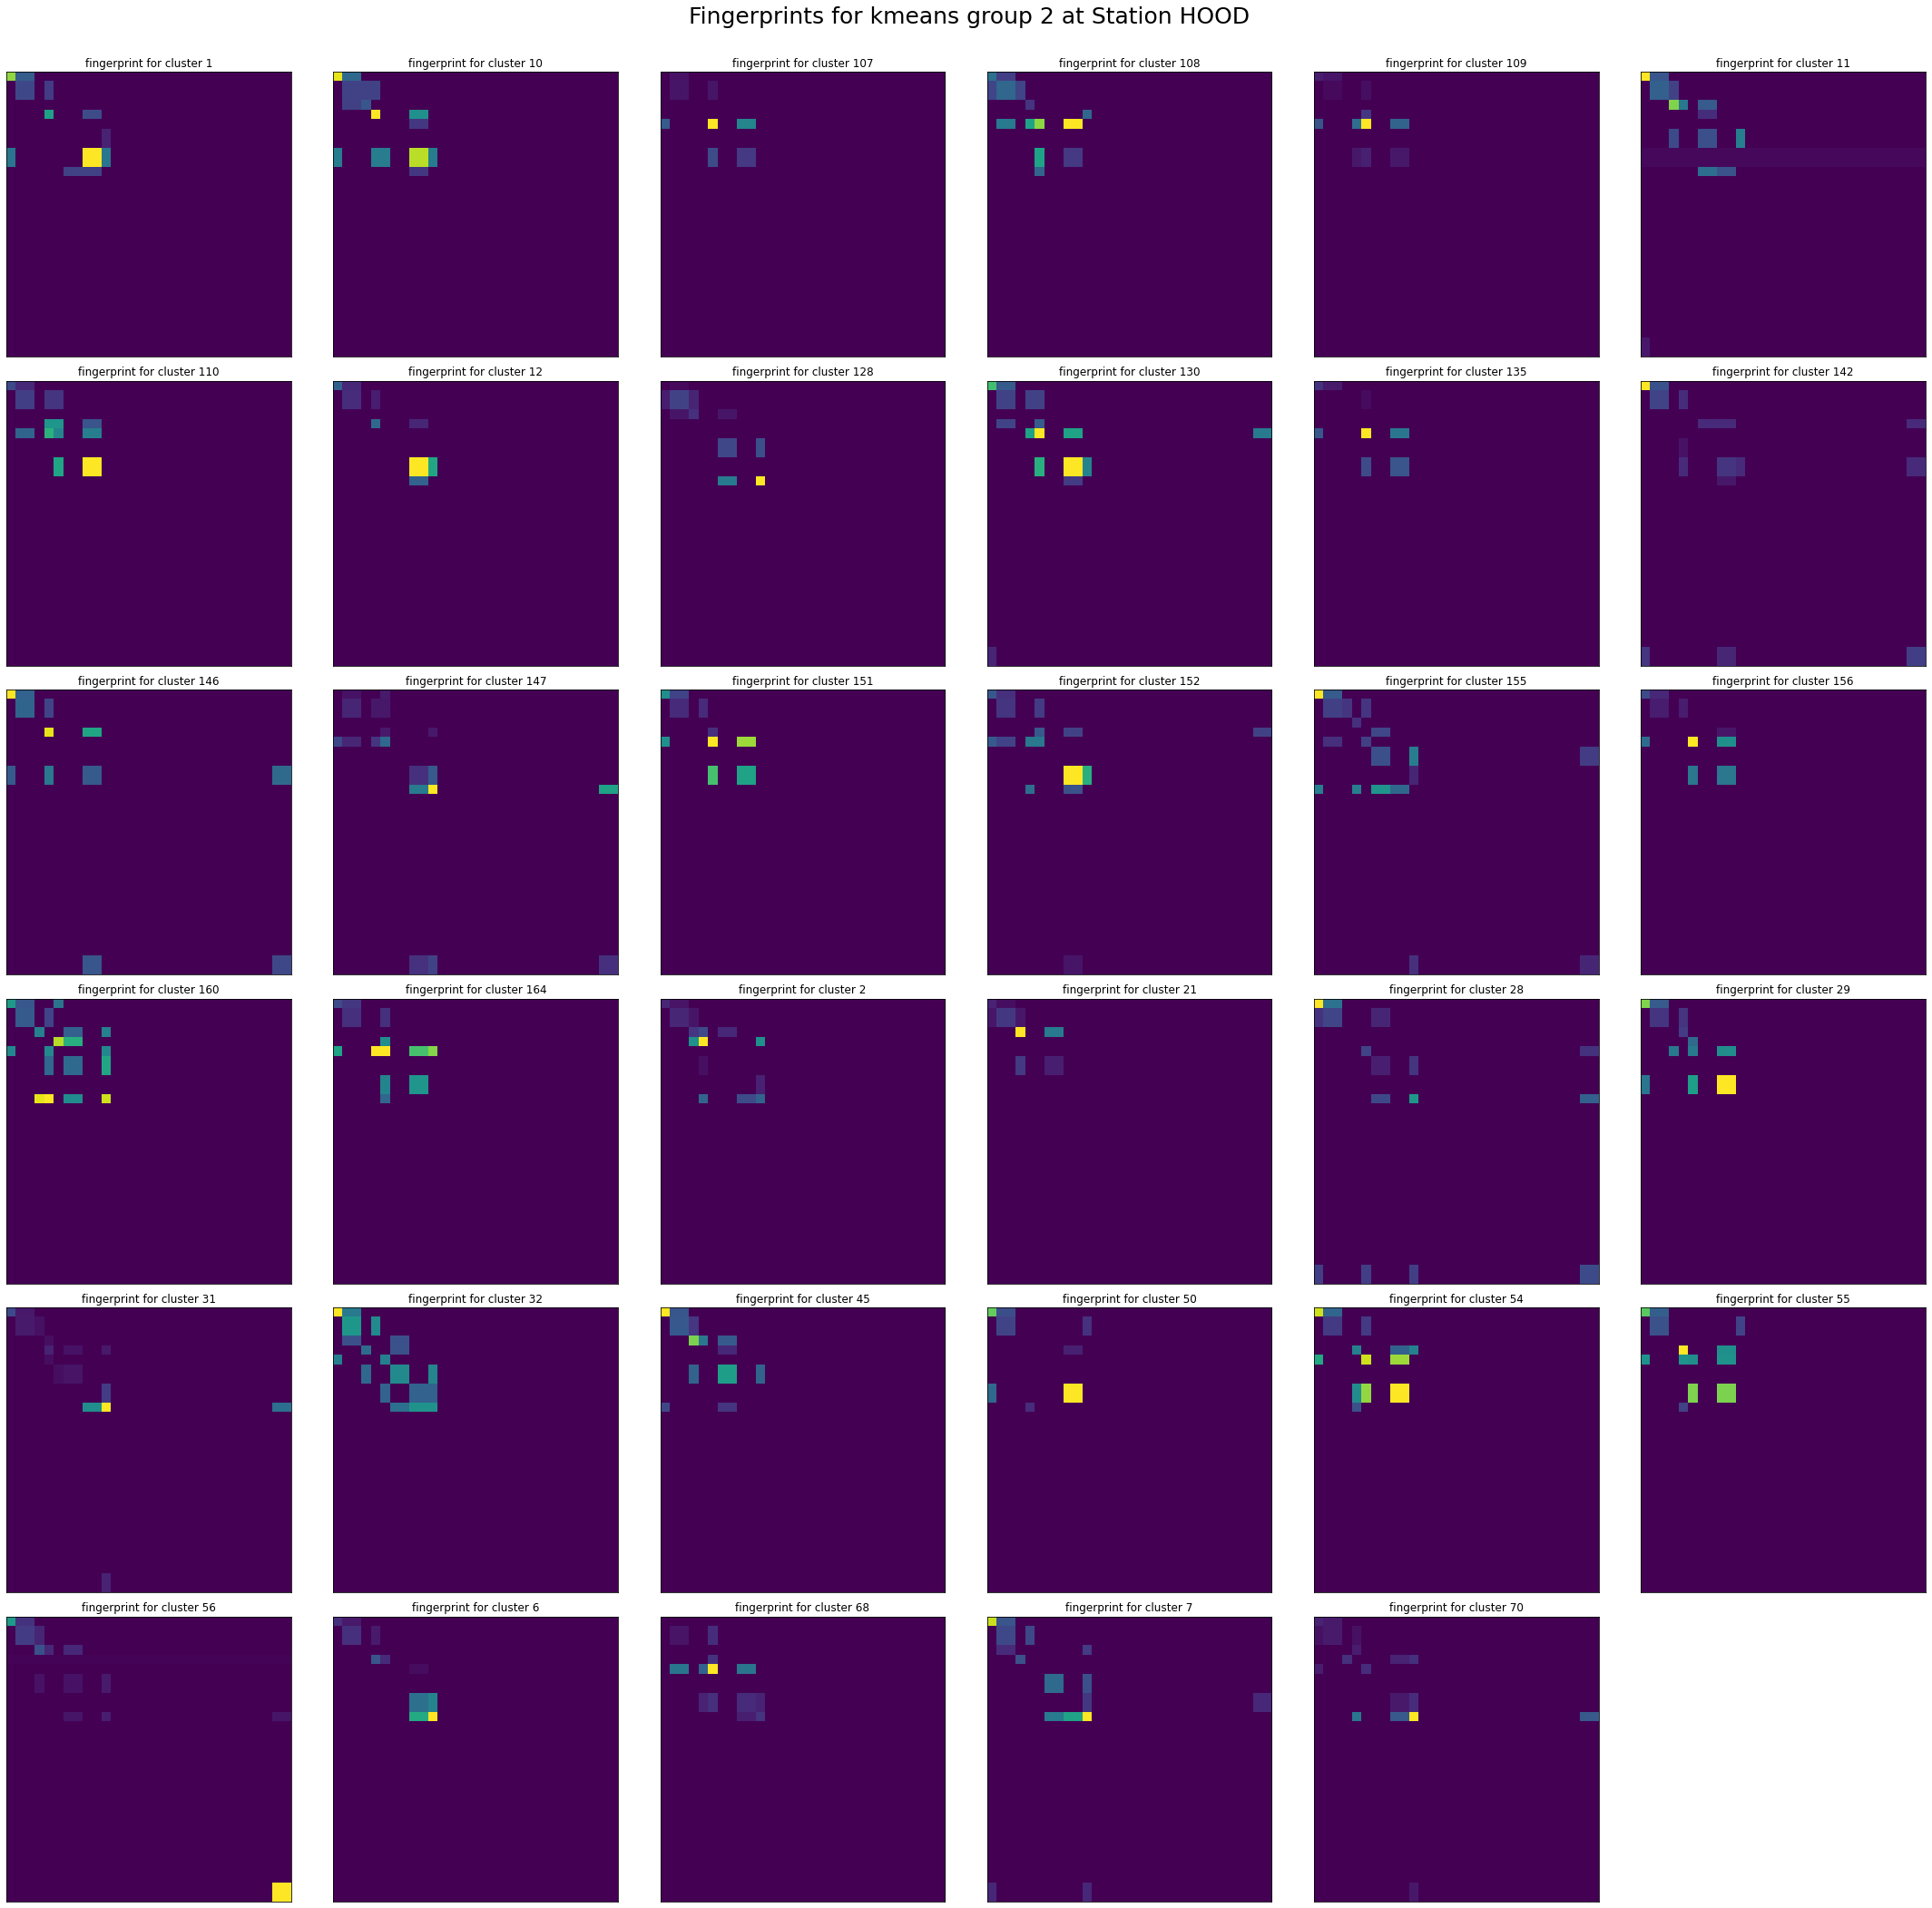

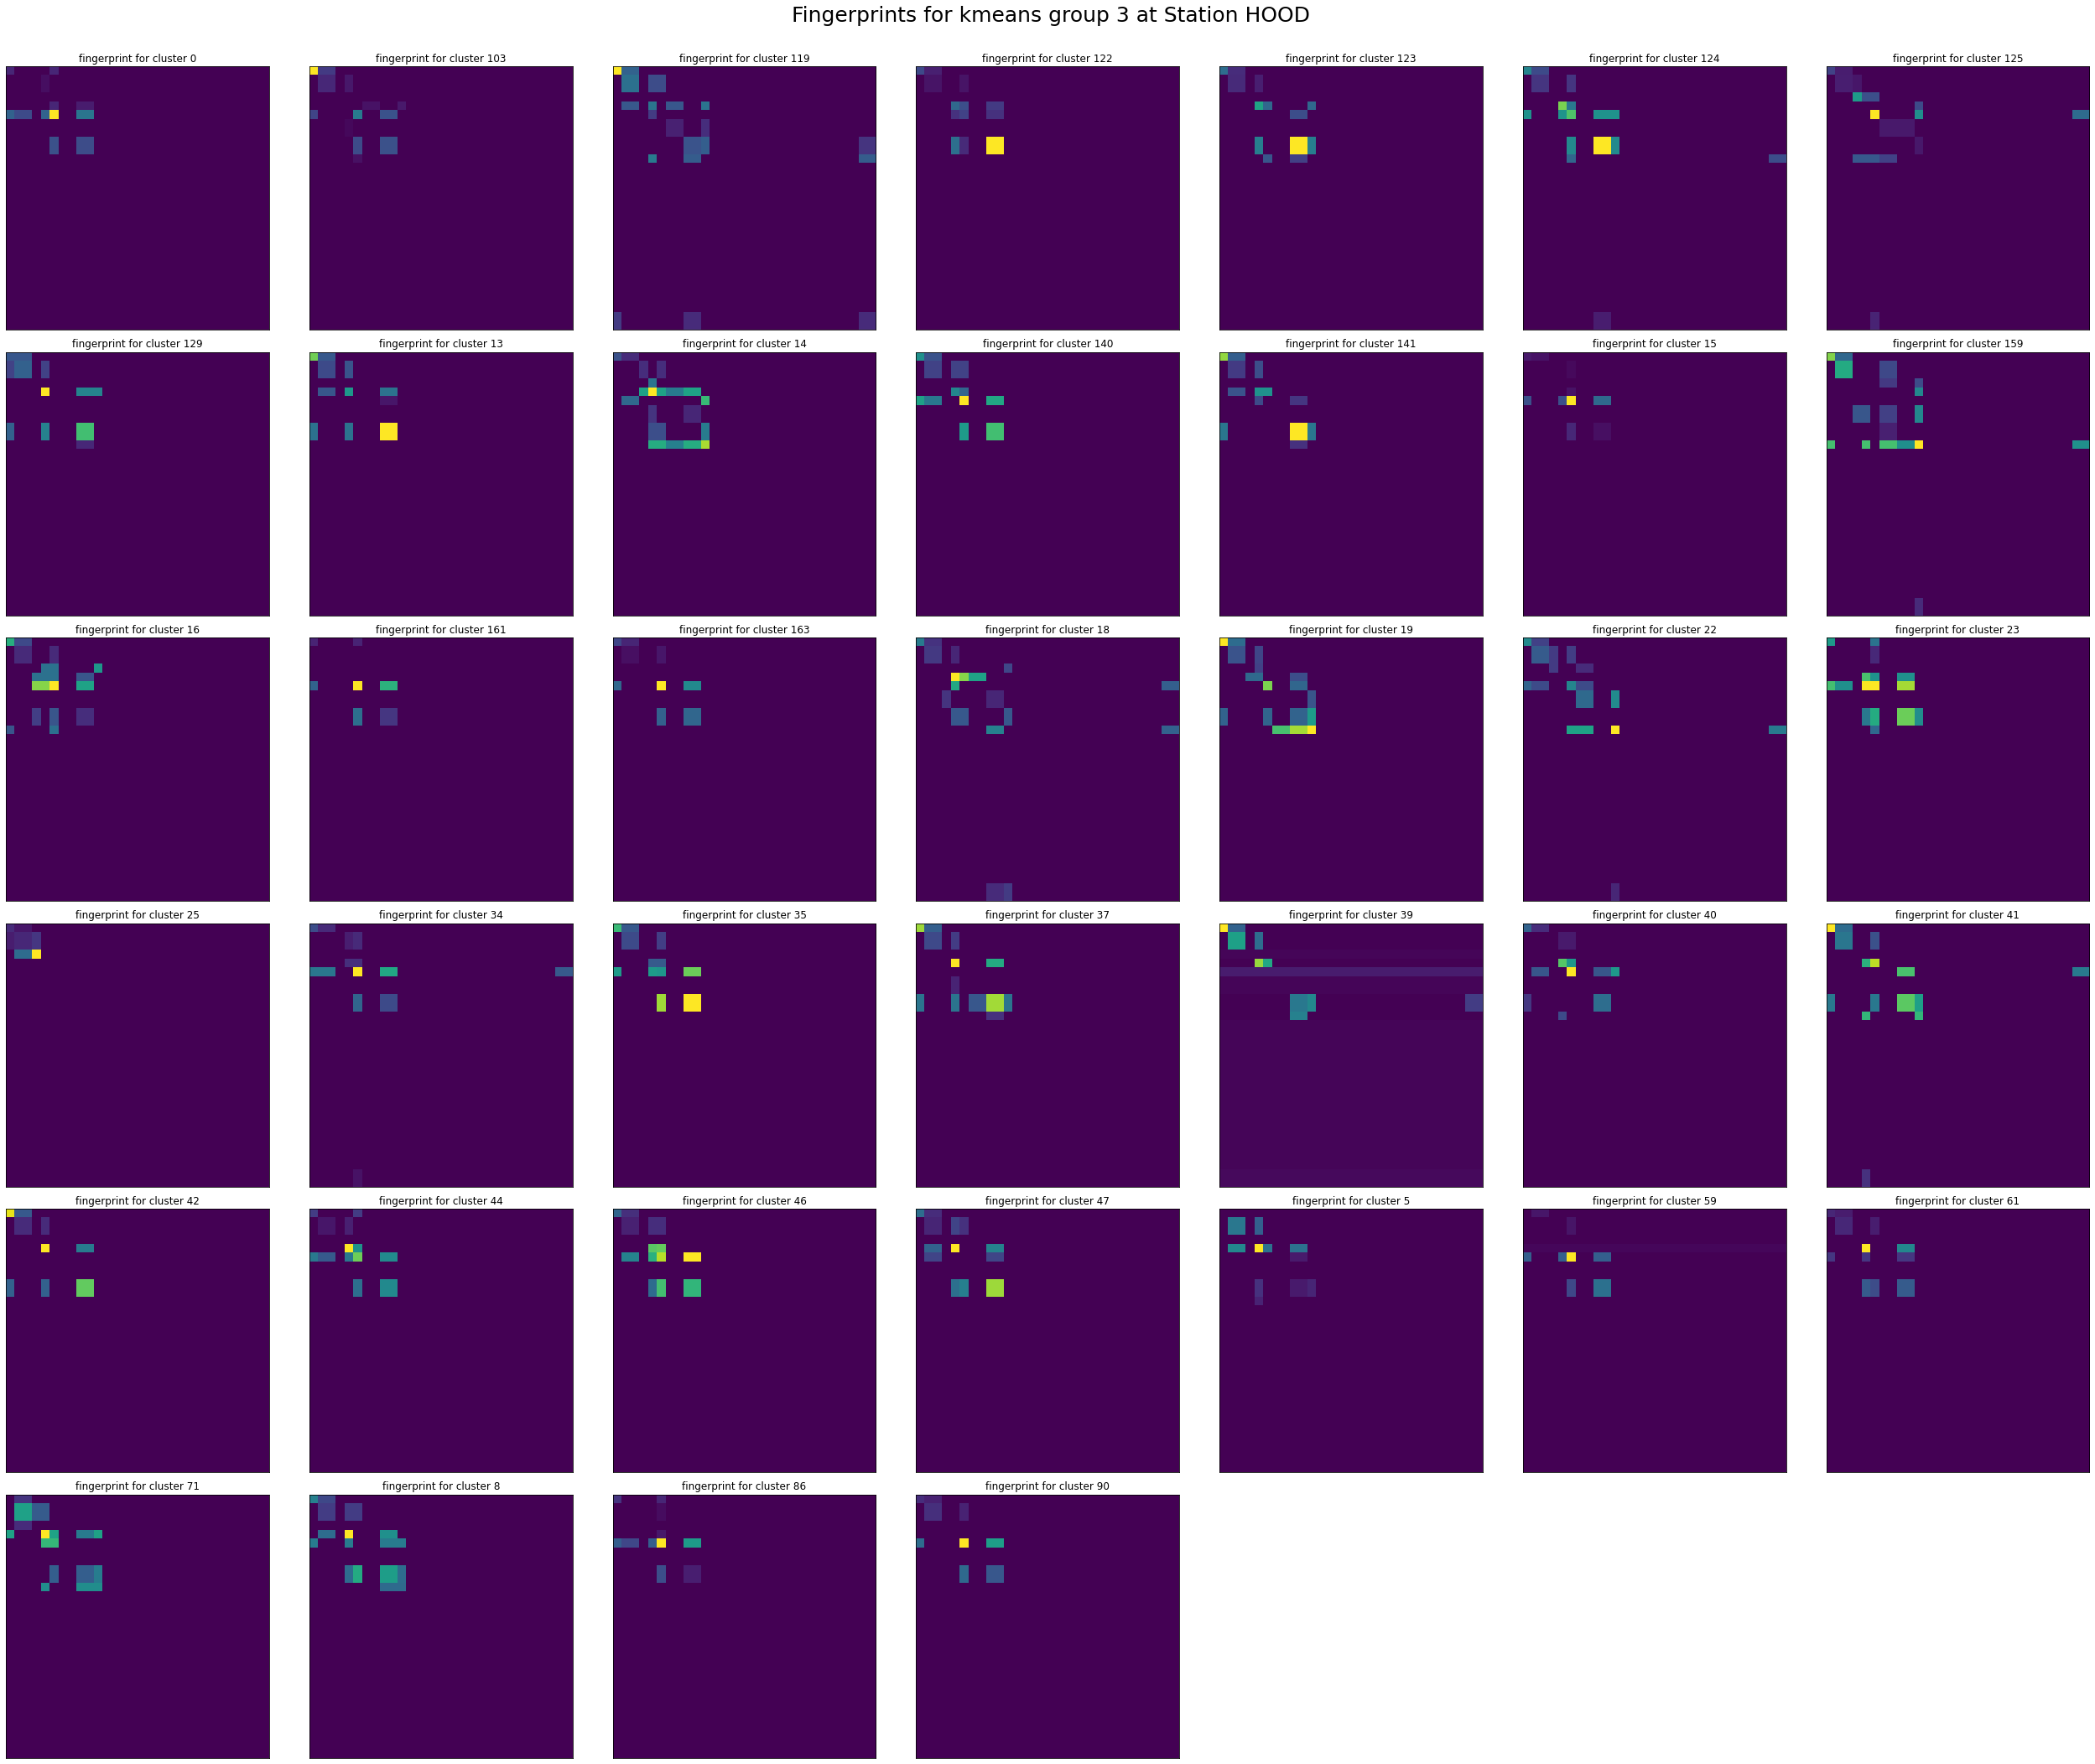

In [60]:
for kn in np.arange(0,k,1): #for each k group
    print_list = fdf[fdf['kmeans']==kn]['fingerprints'].values.tolist() #list of fingerprints for a Kmeans group
    name_list = [getcl_id(i) for i in fdf[fdf['kmeans']==kn]['template_name'].values.tolist()] #list of names for a Kmeans group
    
    ncols=math.ceil(np.sqrt(len(print_list)))
    nrows=math.ceil(len(print_list)/ncols)
    print(f'{len(print_list)} fingerprints in {ncols} columns by {nrows} rows')
    
    del_list = [] #list of empty axes to delete
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*5,nrows*5))
    for rr,row in enumerate(axes):
        for aa,ax in enumerate(row):
            idx = (ncols*rr)+aa
            try:
                ax.imshow(print_list[idx])
                ax.set_title(f'fingerprint for cluster {name_list[idx]}')
                ax.tick_params(axis='both', which='both', bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)
            except:
#                 print(f'axes {idx} is empty')
                del_list.append(ax)
    fig.suptitle(f'Fingerprints for kmeans group {kn} at Station {sta.upper()}',fontsize=25)
    fig.tight_layout(rect=[0, 0, 1, 0.975])
    for i in del_list: #delete empty axes
        fig.delaxes(i)
    plt.show
#     fig.savefig(f'/home/smocz/expand_redpy_new_files/cop_kmeans/{ver}normalized_{volc}_{k}_grp{kn}_{sta.upper()}_prints_{states}_states.svg')
#     break
